In [1]:
import os
import tqdm
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
# PyTorch
import torch
import torchvision
import torchmetrics

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import utils

In [3]:
experiments_directory = '/cluster/home/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
experiments_directory = '/cluster/home/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
#experiments_directory = '/cluster/home/eharve06/bdl-transfer-learning/experiments/tuned_Oxford-IIIT_Pets'
#experiments_directory = '/cluster/home/eharve06/bdl-transfer-learning/experiments/retrained_Oxford-IIIT_Pets'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['ptyl']
ns = [50000]
#ns = [370, 3441]
random_states = [1001, 2001, 3001]
lambds = np.logspace(0, 9 , 10)
taus = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]

#columns = ['avg_sec/epoch', 'method', 'model_name', 'n', 'random_state', 'runtime', 'val_acc', 'val_nll']
columns = ['avg_sec/epoch', 'method', 'model_name', 'n', 'random_state', 'runtime', 'test_acc', 'test_nll']
df = pd.DataFrame(columns=columns)

#for lr_0, method, n, random_state, tau in itertools.product(lr_0s, methods, ns, random_states, taus):
for lambd, lr_0, method, n, random_state, tau in itertools.product(lambds, lr_0s, methods, ns, random_states, taus):
    #model_name = f'{method}_lr_0={lr_0}_n={n}_random_state={random_state}_tau={tau}'
    model_name = f'{method}_lambda={lambd}_lr_0={lr_0}_n={n}_random_state={random_state}_tau={tau}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [temp_df['train_sec/epoch'].mean(), method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.val_or_test_acc1.values[-1], temp_df.val_or_test_nll.values[-1]]
    df.loc[len(df)] = row

FileNotFoundError: [Errno 2] No such file or directory: '/cluster/home/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10/ptyl_lambda=1.0_lr_0=0.1_n=50000_random_state=1001_tau=0.01.csv'

In [4]:
#df.to_csv('tuned_CIFAR-10.csv', index=False)
#df.to_csv('retrained_CIFAR-10.csv', index=False)
#df.to_csv('tuned_Oxford-IIIT_Pets.csv', index=False)
#df.to_csv('retrained_Oxford-IIIT_Pets.csv', index=False)
df.head()

,avg_sec/epoch,method,model_name,n,random_state,runtime,test_acc,test_nll


In [5]:
dataset = 'CIFAR-10'
dataset = 'Oxford-IIIT_Pets'
tuned_df = pd.read_csv(f'/cluster/tufts/hugheslab/eharve06/variational-point-estimation/notebooks/tuned_{dataset}.csv')
retrained_df = pd.read_csv(f'/cluster/tufts/hugheslab/eharve06/variational-point-estimation/notebooks/retrained_{dataset}.csv')
tuned_df.head()

,avg_sec/epoch,method,model_name,n,random_state,runtime,val_acc,val_nll
0,0.795714,l2-sp,l2-sp_lr_0=0.1_n=370_random_state=1001_tau=0.01,370,1001,2387.141541,0.851351,0.578596
1,0.729582,l2-sp,l2-sp_lr_0=0.1_n=370_random_state=1001_tau=0.001,370,1001,2188.747441,0.878378,0.352619
2,0.764705,l2-sp,l2-sp_lr_0=0.1_n=370_random_state=1001_tau=0.0001,370,1001,2294.115335,0.527027,1.795943
3,0.736266,l2-sp,l2-sp_lr_0=0.1_n=370_random_state=1001_tau=1e-05,370,1001,2208.796604,0.500000,2.102345
4,0.722903,l2-sp,l2-sp_lr_0=0.1_n=370_random_state=1001_tau=1e-06,370,1001,2168.708630,0.378378,2.725413


In [ ]:
ns = [100, 1000, 10000, 50000]
ns = [370, 3441]
random_states = [1001, 2001, 3001]

bootstrap_dictionary = {
    n: {
        random_state: np.zeros((100, 24, 500, 2)) for random_state in random_states
    } for n in ns
}

for n, random_state in itertools.product(ns, random_states):
    for bootstap_round_index in tqdm.tqdm(range(100)):
        for num_hypers in range(1,25):
            for bootstap_sample_index in range(500):
                condition = (tuned_df.n==n)&(tuned_df.method=='l2-sp')&(tuned_df.random_state==random_state)
                sampled_tuned_df = tuned_df.loc[condition].sample(n=num_hypers)
                runtime = sampled_tuned_df.runtime.sum()
                best_model_name = sampled_tuned_df.loc[sampled_tuned_df.val_nll.idxmin(), 'model_name']
                test_acc = retrained_df.loc[retrained_df.model_name==best_model_name, 'test_acc'].item()
                runtime += retrained_df.loc[retrained_df.model_name==best_model_name, 'runtime'].item()
                bootstrap_dictionary[n][random_state][bootstap_round_index,num_hypers-1,bootstap_sample_index,0] = runtime
                bootstrap_dictionary[n][random_state][bootstap_round_index,num_hypers-1,bootstap_sample_index,1] = test_acc
                

In [ ]:
#np.save('CIFAR-10_bootstrap_dictionary.npy', bootstrap_dictionary)
#np.save('Oxford-IIIT_Pets_bootstrap_dictionary.npy', bootstrap_dictionary)

In [6]:
cifar10_bootstrap_dictionary = np.load('CIFAR-10_bootstrap_dictionary.npy', allow_pickle=True).item()
oxfordiiit_pets_bootstrap_dictionary = np.load('Oxford-IIIT_Pets_bootstrap_dictionary.npy', allow_pickle=True).item()

In [7]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/informed-priors/experiments/retrained_CIFAR-10_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['avg_sec/epoch', 'method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
cifar10_results_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa={23528522/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [temp_df['train_sec/epoch'].mean(), method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_results_df.loc[len(cifar10_results_df)] = row
    
min_indices = cifar10_results_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
best_cifar10_results = cifar10_results_df.loc[min_indices]
best_cifar10_results['total_time'] = cifar10_results_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [8]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/informed-priors/experiments/retrained_Oxford-IIIT_Pets_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [370, 3441]
random_states = [1001, 2001, 3001]

columns = ['avg_sec/epoch', 'method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
oxfordiiit_pets_results_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa={23583845/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [temp_df['train_sec/epoch'].mean(), method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    oxfordiiit_pets_results_df.loc[len(oxfordiiit_pets_results_df)] = row
    
min_indices = oxfordiiit_pets_results_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
best_oxfordiiit_pets_results_df = oxfordiiit_pets_results_df.loc[min_indices]
best_oxfordiiit_pets_results_df['total_time'] = oxfordiiit_pets_results_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [15]:
def plot_bootstrap_dictionary(ax, bootstrap_dictionary, n, random_states, markers=['o', '^', 's']):
    for index, random_state in enumerate(random_states):
        x = bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(0,2,))
        y = bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(0,2,))
        lower_x, upper_x = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        lower_y, upper_y = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        ax.scatter(x[-1]/3600, y[-1], color='#1F77B4', marker=markers[index], zorder=3)
        ax.plot(x/3600, y, color='#1F77B4', zorder=2)
        ax.fill_between(x/3600, lower_y, upper_y, alpha=0.1, color='#1F77B4', zorder=2)

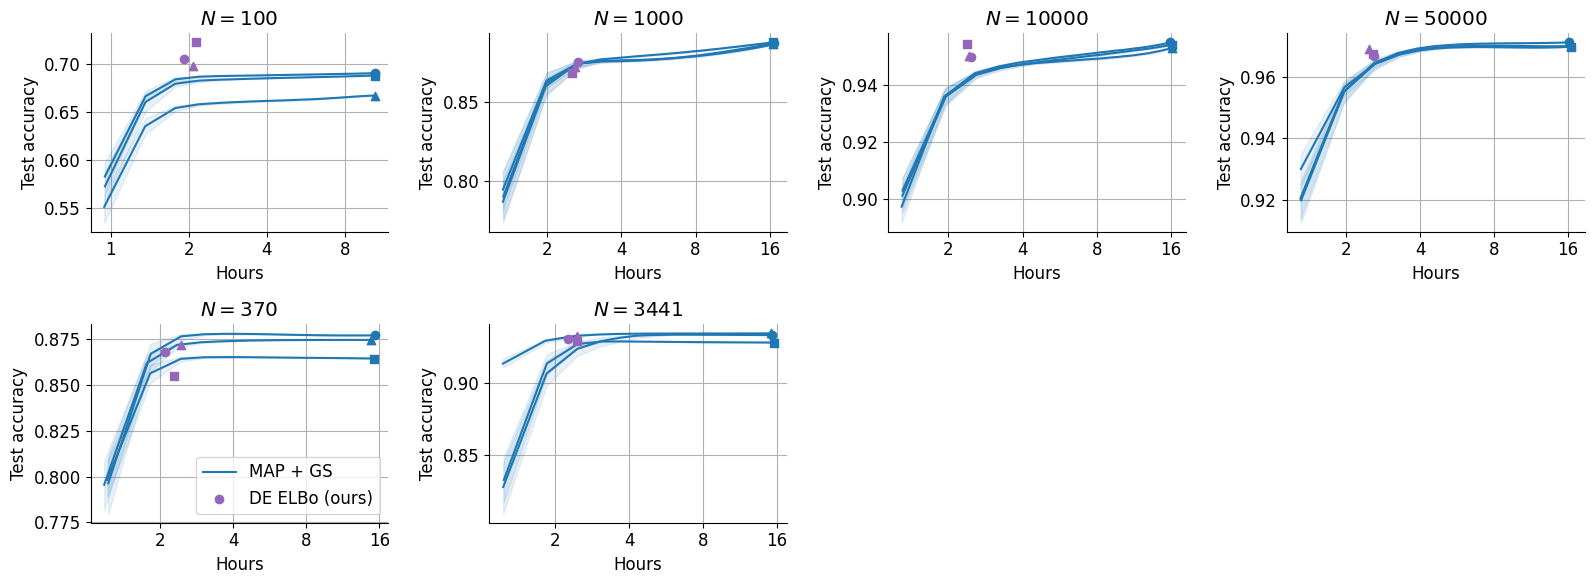

In [21]:
markers = ['o', '^', 's']

ncols, nrows = 4, 2
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)
for index, (time, acc) in enumerate(zip(best_cifar10_results[best_cifar10_results.n==100].total_time.values/3600, best_cifar10_results[best_cifar10_results.n==100].test_acc.values)):
    axs[0,0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_bootstrap_dictionary(axs[0,0], cifar10_bootstrap_dictionary, 100, [1001, 2001, 3001])
axs[0,0].set_xscale('log', base=2)
ticks = axs[0,0].get_xticks()
axs[0,0].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[0,0].spines[['right', 'top']].set_visible(False)
axs[0,0].set_title(r'$N=100$')
axs[0,0].set_xlabel('Hours')
axs[0,0].set_ylabel('Test accuracy')
axs[0,0].grid()
for index, (time, acc) in enumerate(zip(best_cifar10_results[best_cifar10_results.n==1000].total_time.values/3600, best_cifar10_results[best_cifar10_results.n==1000].test_acc.values)):
    axs[0,1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_bootstrap_dictionary(axs[0,1], cifar10_bootstrap_dictionary, 1000, [1001, 2001, 3001])
axs[0,1].set_xscale('log', base=2)
ticks = axs[0,1].get_xticks()
axs[0,1].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[0,1].spines[['right', 'top']].set_visible(False)
axs[0,1].set_title(r'$N=1000$')
axs[0,1].set_xlabel('Hours')
axs[0,1].set_ylabel('Test accuracy')
axs[0,1].grid()
for index, (time, acc) in enumerate(zip(best_cifar10_results[best_cifar10_results.n==10000].total_time.values/3600, best_cifar10_results[best_cifar10_results.n==10000].test_acc.values)):
    axs[0,2].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_bootstrap_dictionary(axs[0,2], cifar10_bootstrap_dictionary, 10000, [1001, 2001, 3001])
axs[0,2].set_xscale('log', base=2)
ticks = axs[0,2].get_xticks()
axs[0,2].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[0,2].spines[['right', 'top']].set_visible(False)
axs[0,2].set_title(r'$N=10000$')
axs[0,2].set_xlabel('Hours')
axs[0,2].set_ylabel('Test accuracy')
axs[0,2].grid()
for index, (time, acc) in enumerate(zip(best_cifar10_results[best_cifar10_results.n==50000].total_time.values/3600, best_cifar10_results[best_cifar10_results.n==50000].test_acc.values)):
    axs[0,3].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_bootstrap_dictionary(axs[0,3], cifar10_bootstrap_dictionary, 50000, [1001, 2001, 3001])
axs[0,3].set_xscale('log', base=2)
ticks = axs[0,3].get_xticks()
axs[0,3].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[0,3].spines[['right', 'top']].set_visible(False)
axs[0,3].set_title(r'$N=50000$')
axs[0,3].set_xlabel('Hours')
axs[0,3].set_ylabel('Test accuracy')
axs[0,3].grid()

axs[1,0].plot([], [], color='#1F77B4', label='MAP + GS', zorder=3)
axs[1,0].scatter([], [], color='#9467BD', label='DE ELBo (ours)', zorder=3)
for index, (time, acc) in enumerate(zip(best_oxfordiiit_pets_results_df[best_oxfordiiit_pets_results_df.n==370].total_time.values/3600, best_oxfordiiit_pets_results_df[best_oxfordiiit_pets_results_df.n==370].test_acc.values)):
    axs[1,0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_bootstrap_dictionary(axs[1,0], oxfordiiit_pets_bootstrap_dictionary, 370, [1001, 2001, 3001])
axs[1,0].set_xscale('log', base=2)
ticks = axs[1,0].get_xticks()
axs[1,0].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[1,0].spines[['right', 'top']].set_visible(False)
axs[1,0].set_title(r'$N=370$')
axs[1,0].set_xlabel('Hours')
axs[1,0].set_ylabel('Test accuracy')
axs[1,0].grid()
axs[1,0].legend()

for index, (time, acc) in enumerate(zip(best_oxfordiiit_pets_results_df[best_oxfordiiit_pets_results_df.n==3441].total_time.values/3600, best_oxfordiiit_pets_results_df[best_oxfordiiit_pets_results_df.n==3441].test_acc.values)):
    axs[1,1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_bootstrap_dictionary(axs[1,1], oxfordiiit_pets_bootstrap_dictionary, 3441, [1001, 2001, 3001])
axs[1,1].set_xscale('log', base=2)
ticks = axs[1,1].get_xticks()
axs[1,1].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[1,1].spines[['right', 'top']].set_visible(False)
axs[1,1].set_title(r'$N=3441$')
axs[1,1].set_xlabel('Hours')
axs[1,1].set_ylabel('Test accuracy')
axs[1,1].grid()

axs[1,2].axis('off')
axs[1,3].axis('off')

fig.tight_layout()
fig.savefig('computational_time_comparison.pdf', bbox_inches='tight')
plt.show()